# Python2 - CCA - Bakas Data

In [1]:
import pandas as pd
import numpy as np


# Append system path to look for additional modules (needed for rcca)
import sys
sys.path.append("/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Packages/")
sys.path.append("/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/kim_code/")

# Import self-build script
import radiogenomics as r

#Plotly 
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

from sklearn.model_selection import train_test_split
import rcca

import seaborn as sns
from scipy.stats.stats import pearsonr   
import math

# Imports
import matplotlib.pyplot as plt
from brewer2mpl import qualitative
%matplotlib inline

# Start with 9 genes, 11 imaging features => interpretable
### Get Gene Data

In [2]:
TCGA = r.download_data("TCGA") 
TCGA = r.make_clean_df("TCGA", TCGA) # (393, 17k)

In [3]:
#  Mutation  status  of  the  9  relevant  genes  in  glioblastom; get source!
# (TP53,  PTEN,  NF1,  EGFR,  IDH1,  PIK3R1,  RB1,  PIK3CA, and  PDGFRA) as Y-block
genes = ['TP53', 'PTEN', 'NF1', 'EGFR', 'IDH1','PIK3R1','RB1','PIK3CA','PDGFRA']
df_selected_genes = TCGA[genes]   # (393,9)

### Imaging Data (UNSURE ABOUT LABELS!)
Based on Bakas 704 features, but only using the Ratios (volume features)

In [4]:
# Download and clean set up dataFrame:
df_TCIA = r.download_data("TCIA")
df_TCIA = r.make_clean_df("TCIA", df_TCIA) # (102,704)

In [5]:
for i in list(df_TCIA.columns):
    if "VOLUME" in i:
        print(i)
        
# Mapping:
# VOLUME_ED = Volume_edema
# VOLUME_ET = Volume_enhanced
# VOLUME_NET = Volume_Necrosis

VOLUME_ET
VOLUME_NET
VOLUME_ED
VOLUME_TC
VOLUME_WT
VOLUME_BRAIN
VOLUME_ET_OVER_NET
VOLUME_ET_OVER_ED
VOLUME_NET_OVER_ED
VOLUME_ET_over_TC
VOLUME_NET_over_TC
VOLUME_ED_over_TC
VOLUME_ET_OVER_WT
VOLUME_NET_OVER_WT
VOLUME_ED_OVER_WT
VOLUME_TC_OVER_WT
VOLUME_ET_OVER_BRAIN
VOLUME_NET_OVER_BRAIN
VOLUME_ED_over_BRAIN
VOLUME_TC_over_BRAIN
VOLUME_WT_OVER_BRAIN


In [6]:
%%capture
# VOLUME_ED = Volume_edema
# VOLUME_ET = Volume_enhanced
# VOLUME_NET = Volume_Necrosis

# Above is used to suppress warnings!
img_features = ['VOLUME_ED', 'VOLUME_ET', 'VOLUME_NET']
df_img = df_TCIA[img_features]
df_img.columns = ['Edema', 'Enhancing', 'Necrosis'] # Rename

# Add sums
df_img['Tumor Bulk'] = df_img['Necrosis'] + df_img['Enhancing']
df_img['Total Tumor Volume'] = df_img['Necrosis'] + df_img['Enhancing'] + df_img['Edema']

# Add ratios
df_img['Necrosis / Contrast-Enhancing'] = df_img['Necrosis'] / df_img['Enhancing']
df_img['Contrast-Enhancing / Tumo Bulk'] = df_img['Enhancing'] / df_img['Tumor Bulk']
df_img['Contrast-enhancing / Total Tumor Volume'] = df_img['Enhancing'] / df_img['Total Tumor Volume']
df_img['Necrosis / Total Tumor Volume'] = df_img['Necrosis'] / df_img['Total Tumor Volume']
df_img['Edema / Total Tumor Volume'] = df_img['Edema'] / df_img['Total Tumor Volume']
df_img['Tumor Bulk / Total Tumor Volume'] = df_img['Tumor Bulk'] / df_img['Total Tumor Volume']

### Only Matches (57)

In [7]:
# Get matches
matches = r.find_matches(df_img, df_selected_genes)

# Only keep rows based on matches
df_img = df_img.loc[matches,:].astype(float) # (57,11); need to turn into float
df_selected_genes = df_selected_genes.loc[matches,:].astype(float) # (57,9)

## CCA
### Train

In [8]:
# Split into test and training (img=X, genes=Y)
X_train, X_test, y_train, y_test = train_test_split(df_img, # X
                                                    df_selected_genes, # Y
                                                    test_size=0.33, 
                                                    random_state=42)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

('X_train:', (38, 11))
('X_test:', (19, 11))
('y_train:', (38, 9))
('y_test:', (19, 9))


In [9]:
# Number components as the maximum possible 
nComponents = min(df_img.shape[1],
                  df_selected_genes.shape[1])
print("nComponents:", nComponents)

# Create object
cca = rcca.CCA(kernelcca = False, 
               reg = 0.00001,   # Needed regularisation for some reason
               numCC = nComponents)

# Use the train() method to find a CCA mapping between the two training sets.
cca.train([X_train, y_train])

('nComponents:', 9)
Training CCA, kernel = None, regularization = 0.0000, 9 components


### Correlation

In [10]:
# Training correlation
print("Components:", len(cca.cancorrs))
cca.cancorrs

('Components:', 9)


array([0.85380661, 0.82327554, 0.68574076, 0.59042737, 0.4891144 ,
       0.41723527, 0.17644011, 0.06481364, 0.01142947])

### Interpreting weights (feature importance)
First column of weights map to the first canonical components

In [11]:
# rows = features, cols = components
print("weights_img rows:",len(cca.ws[0]))
print("weights_img cols:",len(cca.ws[0][0]))  
print("\n")  
print("weights_genes rows:",len(cca.ws[1]))
print("weights_genes cols:",len(cca.ws[1][0]))  

('weights_img rows:', 11)
('weights_img cols:', 9)


('weights_genes rows:', 9)
('weights_genes cols:', 9)


In [12]:
# Images 
cols_img = list(df_img.columns)
index = 0
dict_img = {}
for i in cca.ws[0][0]:
    print(cols_img[index] + " Has relative weight of: " + str("{0:.5f}".format(i/sum(cca.ws[0][0]))))
    dict_img[cols_img[index]] = i/sum(cca.ws[0][0])
    index +=1

Edema Has relative weight of: 0.00000
Enhancing Has relative weight of: -0.00000
Necrosis Has relative weight of: -0.00000
Tumor Bulk Has relative weight of: -0.00000
Total Tumor Volume Has relative weight of: -0.00000
Necrosis / Contrast-Enhancing Has relative weight of: 0.00000
Contrast-Enhancing / Tumo Bulk Has relative weight of: -0.00000
Contrast-enhancing / Total Tumor Volume Has relative weight of: -0.00000
Necrosis / Total Tumor Volume Has relative weight of: 1.00000


In [13]:
# Genes
cols_genes = list(df_selected_genes.columns)
index = 0
dict_genes = {}
for i in cca.ws[1][0]:
    print(cols_genes[index] + " Has relative weight of: " + str("{0:.5f}".format(i/sum(cca.ws[1][0]))))
    dict_genes[cols_genes[index]] = i/sum(cca.ws[1][0])
    index += 1

TP53 Has relative weight of: -0.33336
PTEN Has relative weight of: -0.44219
NF1 Has relative weight of: 0.51700
EGFR Has relative weight of: -0.41893
IDH1 Has relative weight of: 0.52546
PIK3R1 Has relative weight of: 0.79160
RB1 Has relative weight of: 0.79279
PIK3CA Has relative weight of: -0.62528
PDGFRA Has relative weight of: 0.19291


### Plot of feature correlations with component pair 1
### NB: Negative weights are important too! So just take the tails
Gene first, then images

In [15]:
df_gene_weights = pd.DataFrame(data=dict_genes.values(), 
                               index=dict_genes.keys(), 
                               columns=['Genes'])
# Sort 
df_gene_weights= df_gene_weights.sort_values(by=['Genes'], ascending=False).T
df_gene_weights

# Construct cmap
#my_cmap = sns.light_palette("Navy", as_cmap=True)

# Plot
#plt.figure(figsize=(12,6))
#plt.title('Gene weight in first canonical pair')
#sns.heatmap(df_gene_weights, cmap=my_cmap, annot=True)

RB1    PIK3R1      IDH1       NF1    PDGFRA      TP53      EGFR  \
Genes  0.79279  0.791601  0.525459  0.517004  0.192911 -0.333357 -0.418934   

           PTEN    PIK3CA  
Genes -0.442195 -0.625279

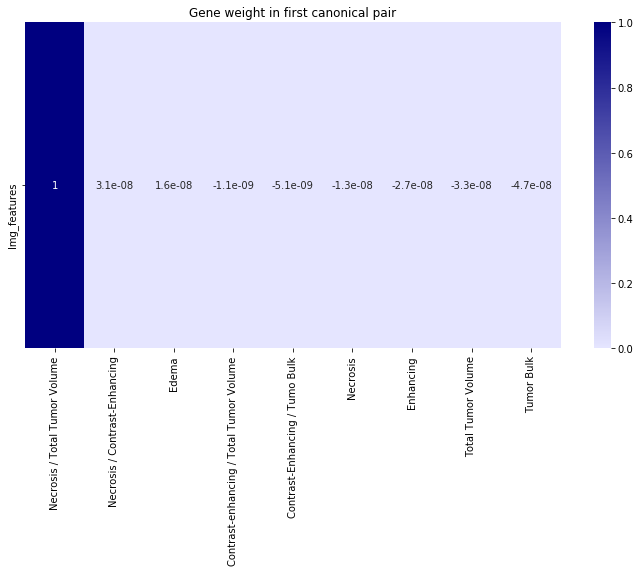

In [211]:
df_img_weights = pd.DataFrame(data=dict_img.values(), 
                               index=dict_img.keys(), 
                               columns=['Img_features'])
# Sort 
df_img_weights= df_img_weights.sort_values(by=['Img_features'], ascending=False).T

# Plot
plt.figure(figsize=(12,6))
plt.title('Gene weight in first canonical pair')
sns.heatmap(df_img_weights, cmap=my_cmap, annot=True)

### Validation (how well we can predict gene features) 
# QUESITON: Is it better to look at prediction than canonical correlation on the test set?
Plot 

In [14]:
# Use the validate() method to test how well the CCA mapping generalizes to the test data.
testcorrs = cca.validate([X_test, y_test]) 
print("Number of img correlations:", len(cca.corrs[0]))
print("Number of gene correlations:", len(cca.corrs[1]))
print("\n")
print("correlations to gene data: ", cca.corrs[1])

('Number of img correlations:', 11)
('Number of gene correlations:', 9)


('correlations to gene data: ', array([ 0.00411331,  0.15206511,  0.18271886,  0.10055044,  0.24382478,
        0.        ,  0.24344608, -0.05875382,  0.        ]))


/Users/kimrants/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning:

invalid value encountered in true_divide

/Users/kimrants/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning:

invalid value encountered in true_divide



In [313]:
# Algorithm to get all correlation between prediction for genes and their values in test set
# Also get the p-values to assess significance
dict_results = {}

feat = 0
for gene in cols_genes: 
    dict_results[gene] = pearsonr([i[feat] for i in cca.preds[1]],
                                  y_test.loc[:,gene])
    #Replace nan with 0
    if math.isnan(dict_results[gene][0]):
        temp = list(dict_results[gene])
        temp[0] = 0
        dict_results[gene] = temp
    feat +=1

#NB: "NaN" or 0 result occurs if there were ZERO mutations in gene data; correlation = 0

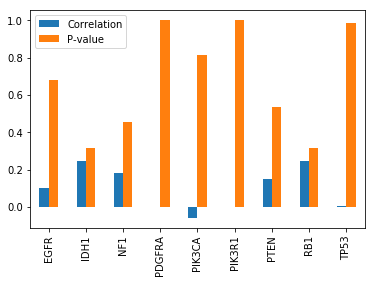

In [329]:
# Plot correlation (add p-Value?)
# Set up data
df = pd.DataFrame(dict_results).T
df.columns = ['Correlation', 'P-value']

# Plot
df.plot(kind='bar')
plt.show()

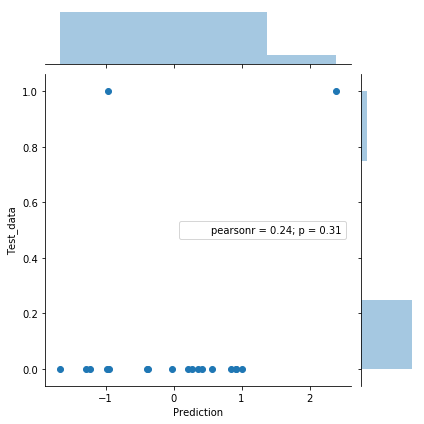

In [302]:
# Plot Joint plot for IDh1 as example (probably don't use)
df = pd.DataFrame(data=[[i[4] for i in cca.preds[1]], 
                        list(y_test.loc[:,'IDH1'])], 
                  index=['Prediction','Test_data']).T

g = sns.jointplot(x="Prediction", y="Test_data", data=df)